<a href="https://colab.research.google.com/github/VKSi/2020_12_DataCompetitions_Course/blob/main/HW_1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Урок 1. Введение в спортивный анализ данных, Exploration Data Analysis.

#### Домашнее задание 1:
Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;     

Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;     

Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;     

Задание 4: Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;     

Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?     

Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.     

Задание 7: Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.     


Ссылка на наборы данных: https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing     

p.s. это обязательная программа для выполнения домашки, вы можете расширить эту программу и сделать больше; я только за :)

### Решение

In [ ]:
# !pip install missingno

In [ ]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

#### Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;     

Загрузим данные

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Проверим размерность датасетов

In [ ]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


Проверим различие в фитчах (должны различаться только на таргет:

In [ ]:
set(train.columns) - set(test.columns)

{'target'}

Создадим объединенный сет (без таргета на трейне) для анализа общих характеристик:

In [ ]:
union = pd.concat([train.drop('target', axis = 'columns'), test], axis=0, ignore_index=True)
union.shape

(400000, 201)

Посчитаем базовые статистики:

In [ ]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [ ]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


In [ ]:
union.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,...,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,10.669326,-1.625933,10.711322,6.792372,11.077366,-5.057938,5.412056,16.537496,0.280648,7.568322,...,3.212103,7.448339,1.926891,3.326895,17.995376,-0.137873,2.297117,8.910293,15.869952,-3.286439
std,3.038398,4.045275,2.637393,2.048028,1.619805,7.866274,0.865652,3.421286,3.333002,1.233468,...,4.555632,3.024243,1.479193,3.993813,3.137905,1.429530,5.450356,0.921266,3.009828,10.418385
min,0.188700,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.216400,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-39.457800
25%,8.448900,-4.720800,8.729700,5.242175,9.886975,-11.200825,4.770200,13.938200,-2.310825,6.621500,...,-0.077200,5.161900,0.886700,0.586075,15.632400,-1.165900,-1.947800,8.255800,13.838500,-11.171300
50%,10.518950,-1.599400,10.570000,6.823700,11.104500,-4.833700,5.388500,16.439800,0.383100,7.630800,...,3.181700,7.363700,1.897000,3.410900,17.967100,-0.167600,2.406800,8.890600,15.939200,-2.769700
75%,12.748225,1.350025,12.505300,8.326000,12.256800,0.934700,6.004300,19.099000,2.934025,8.584600,...,6.373200,9.521700,2.952800,6.191400,20.393800,0.834000,6.539300,9.594900,18.055325,4.889400
max,22.323400,10.376800,19.353000,13.188300,16.671400,17.253700,8.447700,28.292800,10.151300,11.150600,...,20.359000,16.716500,8.402400,18.281800,27.947800,4.545400,18.321500,12.275800,26.538400,28.500700


In [ ]:
union.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
union.tail()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
399995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
399996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
399997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
399998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122
399999,test_199999,10.4664,1.8070,10.2277,6.0654,10.0258,1.0789,4.8879,14.4892,-0.5902,...,0.1398,9.2828,1.3601,4.8985,20.0926,-1.3048,-2.5981,10.3378,14.3340,-7.7094


Проверим наличие пропусков

In [ ]:
union.isnull().sum().sum()

0

#### Выводы:     
1) Наборы данных содержат одинаковые (за исключением таргета) признаки. 200 реальных признаков и один технический (ID).     
2) Наборы содержат одинаковое количество наблюдений (200,000).     
3) Выглядит достаточно скучным и неэффективным занятием изучать статистику по describe по 200 безымянных переменных. Выводы по статистикам и распределениям имеет смысл делать после разделения данных по типам и формирования визуальнизаций статистик (Задание 4).     
4) Пропусков нет.

#### Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;     

In [ ]:
target = train['target']

NameError: ignored

In [ ]:
target.value_counts()

NameError: ignored

In [ ]:
target.value_counts()/len(target)*100

In [ ]:
_ = target.value_counts().plot(kind='bar')
plt.show()

#### Выводы:     
1) Таргет является бинарной величиной. Задача предсказания будет являться задачей бинарной классификации     
2) Распределение значений таргета несбалансировано. ПОзитивных целевых наблюдений только 10%

####  Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

Для того, чтобы построить распределение признаков, сначала разделим признаки по их типам.

In [ ]:
train.dtypes.value_counts()

float64    200
int64        1
object       1
dtype: int64

In [ ]:
train.select_dtypes(['int64']).columns

Index(['target'], dtype='object')

In [ ]:
train.select_dtypes(['object']).columns

Index(['ID_code'], dtype='object')

Таким образом все признаки являются числовыми.     
Проверим, нет ли среди числовых признаков признаков с малым количеством уникальных значений, которые могут быть категориальными:

In [ ]:
features = [col for col in test.columns if col != 'ID_code']

In [ ]:
discrete_feature = [feature for feature in features if len(train[feature].unique())<25]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 0


Признаков, похожих на категориальные нет.

Создадим набор признаков для анализа

In [ ]:
essential_features = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26', 'var_40', 'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']

In [ ]:
len(essential_features)

18

Посмотрим на распредедения признаков по train и test выборкам, включая тест Колмогорова-Смирнова:

In [ ]:
from scipy.stats import kstest, ks_2samp

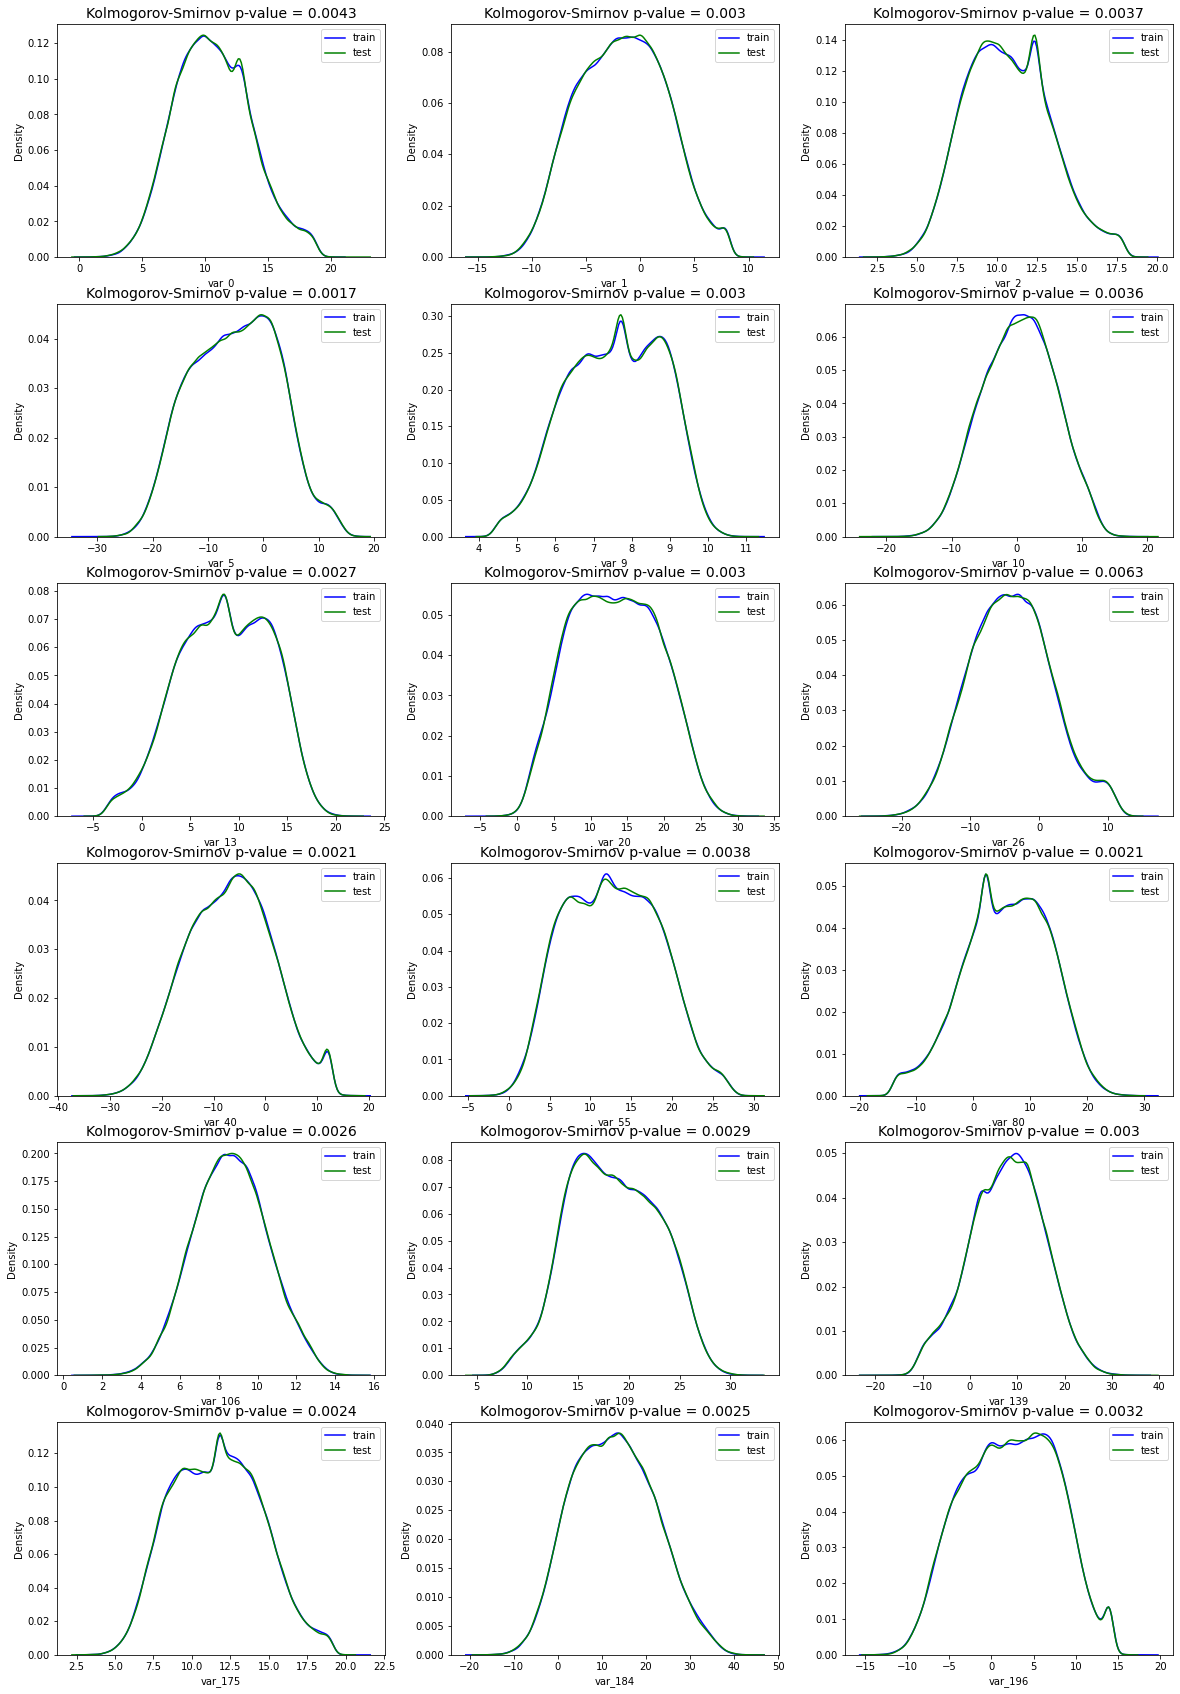

In [ ]:
fig, axes = plt.subplots(6, 3, figsize=(20, 30))
ks_tt = dict()

for num, feature in enumerate(essential_features):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
    ks_tt[feature] = round(ks_2samp(train_data, test_data)[0], 4)
    axes[num//3, num%3].set_title(f'Kolmogorov-Smirnov p-value = {ks_tt[feature]}', fontsize=14)
    axes[num//3, num%3].legend()

In [ ]:
ks_tt_df = pd.DataFrame(columns= ['feature', 'KS p-value'])
for key, value in ks_tt.items():
    ks_tt_df.loc[ks_tt_df.shape[0] + 1, 'feature'] = key
    ks_tt_df.loc[ks_tt_df.shape[0], 'KS p-value'] = value
ks_tt_df = ks_tt_df.sort_values(by='KS p-value', ascending = False).reset_index()
ks_tt_df

,index,feature,KS p-value
0,7,var_13,0.088
1,17,var_184,0.082
2,11,var_55,0.076
3,6,var_10,0.06
4,2,var_1,0.06
5,14,var_109,0.056
6,8,var_20,0.054
7,3,var_2,0.05
8,16,var_175,0.05
9,10,var_40,0.048


Сделаем то же самое для сравнения распределений выборки train в зависимости от значения целевой переменной:

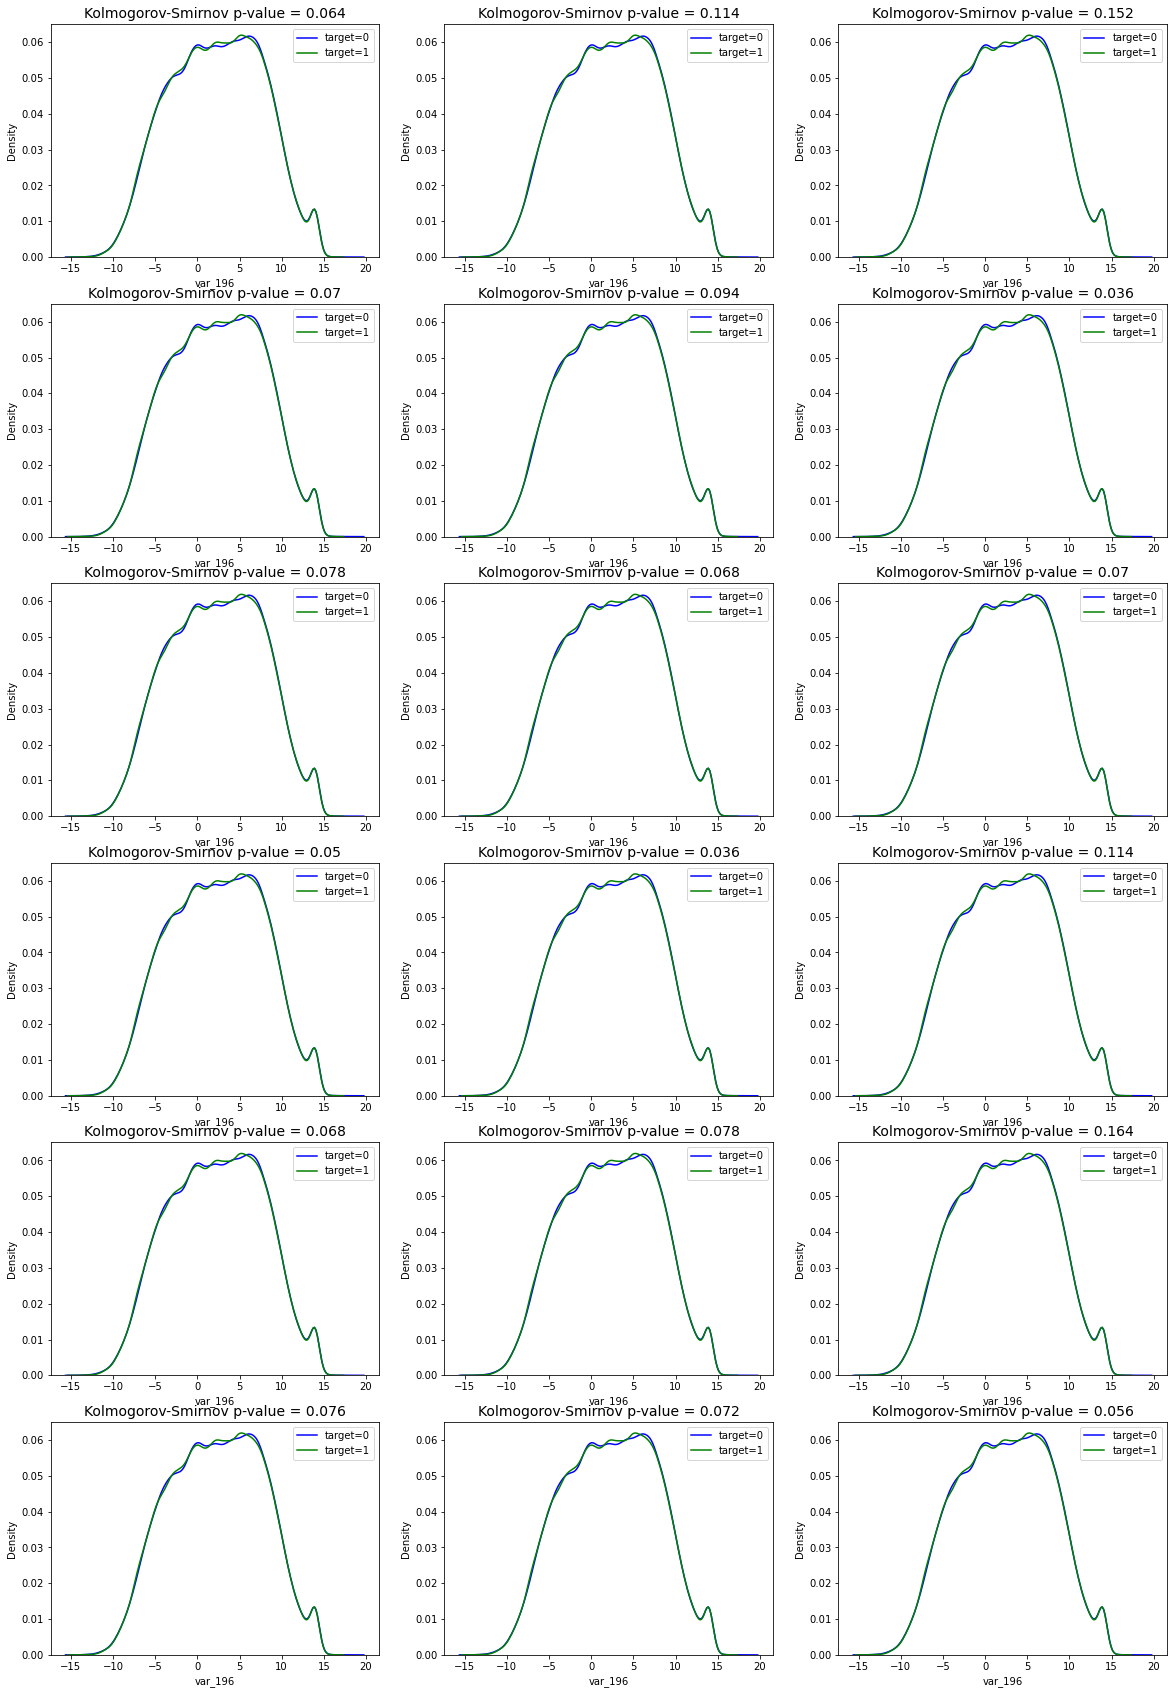

In [ ]:
fig, axes = plt.subplots(6, 3, figsize=(20, 30))
ks_target = dict()

for num, feature in enumerate(essential_features):
    try:
        target_0, target_1 = train.loc[train.target == 0, feature].copy(), train.loc[train.target == 1, feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        target_0 = train.loc[train.target == 0, feature].copy()
        sns.kdeplot(target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
    ks_target[feature] = round(ks_2samp(target_0.sample(500), target_1.sample(500))[0], 4)
    axes[num//3, num%3].set_title(f'Kolmogorov-Smirnov p-value = {ks_target[feature]}', fontsize=14)
    axes[num//3, num%3].legend()

In [ ]:
ks_target_df = pd.DataFrame(columns= ['feature', 'KS p-value'])
for key, value in ks_target.items():
    ks_target_df.loc[ks_target_df.shape[0] + 1, 'feature'] = key
    ks_target_df.loc[ks_target_df.shape[0], 'KS p-value'] = value
ks_target_df = ks_target_df.sort_values(by='KS p-value', ascending = False).reset_index()
ks_target_df

,index,feature,KS p-value
0,15,var_139,0.164
1,3,var_2,0.152
2,2,var_1,0.114
3,12,var_80,0.114
4,5,var_9,0.094
5,7,var_13,0.078
6,14,var_109,0.078
7,16,var_175,0.076
8,17,var_184,0.072
9,4,var_5,0.07


#### Выводы:     
1) Распределения для тестовой и тренировочной выборки визуально смотрятся достаточно похожими. Однако для всех признаков тест КОлмогорова-Смирнова дает малое значение p-value (от 0.0017 до 0.0063). Мы вынуждены с вероятностью более 99% отвергнуть гипотезу о том, что распределения соответствуют двум выборкам из одной популяции, что неприятно.     
2) Распределение непрерывных переменных в тренировочном наборе данных для разных значений целевой переменной визуально также очень похожи. Гипотезу о том, что выборки сделаны из одной популяции с вероятностью более 95% не удается опровергнуть для 16 из 18 признаков. Возможно, эти признаки почти не влияют на значение целевой переменной.

####  Задание 4: Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы; 

In [ ]:
def stats_tt(features_set):
    stats_tt = pd.DataFrame(columns= ['feature', 'mean train', 'mean test', 'std train', 'std test', 'mean z-score', 'std diff'])
    for f in features_set:
        stats_tt.loc[stats_tt.shape[0] + 1, 'feature'] = f
        stats_tt.loc[stats_tt.shape[0], 'mean train'] = train[f].mean()
        stats_tt.loc[stats_tt.shape[0], 'mean test'] = test[f].mean()
        stats_tt.loc[stats_tt.shape[0], 'std train'] = train[f].std()
        stats_tt.loc[stats_tt.shape[0], 'std test'] = test[f].std()
    stats_tt['mean z-score'] = abs(stats_tt['mean train'] - stats_tt['mean test'])/stats_tt['std train']
    stats_tt['std diff'] = abs(stats_tt['std test'] - stats_tt['std train'])/stats_tt['std train']
    return stats_tt

In [ ]:
stats_tt(features)[['feature', 'mean z-score']].sort_values(by='mean z-score', ascending=False).head(10)

,feature,mean z-score
91,var_90,0.0162073
89,var_88,0.0140982
27,var_26,0.0120583
161,var_160,0.0103967
190,var_189,0.00983409
191,var_190,0.00979699
47,var_46,0.0093503
162,var_161,0.00921328
54,var_53,0.00887433
124,var_123,0.00851059


In [ ]:
stats_tt(features)[['feature', 'std diff']].sort_values(by='std diff', ascending=False).head(10)

,feature,std diff
170,var_169,0.00998039
181,var_180,0.00678326
96,var_95,0.00642304
169,var_168,0.00629192
83,var_82,0.0062484
177,var_176,0.00573093
84,var_83,0.00562142
187,var_186,0.00529039
18,var_17,0.00504238
17,var_16,0.00491148


In [ ]:
def stats_target(features_set):
    stats_target = pd.DataFrame(columns= ['feature', 'mean target 0', 'mean target 1', 'std target 0', 'std target 1', 'mean z-score', 'std diff'])
    for f in features_set:
        stats_target.loc[stats_target.shape[0] + 1, 'feature'] = f
        stats_target.loc[stats_target.shape[0], 'mean target 0'] = train.loc[train.target == 0, f].mean()
        stats_target.loc[stats_target.shape[0], 'mean target 1'] = train.loc[train.target == 1, f].mean()
        stats_target.loc[stats_target.shape[0], 'std target 0'] = train.loc[train.target == 0, f].std()
        stats_target.loc[stats_target.shape[0], 'std target 1'] = train.loc[train.target == 1, f].std()
    stats_target['mean z-score'] = abs(stats_target['mean target 0'] - stats_target['mean target 1'])/stats_target['std target 0']
    stats_target['std diff'] = abs(stats_target['std target 1'] - stats_target['std target 0'])/stats_target['std target 0']
    return stats_target

In [ ]:
stats_target(features)[['feature', 'mean z-score']].sort_values(by='mean z-score', ascending=False).head(10)

,feature,mean z-score
82,var_81,0.274095
140,var_139,0.249616
13,var_12,0.234357
7,var_6,0.224184
111,var_110,0.216461
147,var_146,0.214199
54,var_53,0.213226
27,var_26,0.210263
77,var_76,0.208047
175,var_174,0.207197


In [ ]:
(stats_target(features)['mean z-score'] > 0.01).sum()

189

In [ ]:
stats_target(features)[['feature', 'std diff']].sort_values(by='std diff', ascending=False).head(10)

,feature,std diff
82,var_81,0.141219
13,var_12,0.109336
27,var_26,0.10229
180,var_179,0.0995012
111,var_110,0.0993281
45,var_44,0.0992562
140,var_139,0.098108
147,var_146,0.0938406
81,var_80,0.0937438
199,var_198,0.0905087


In [ ]:
(stats_target(features)['std diff'] > 0.01).sum()

153

#### Выводы:     
1) При сравнении тестовой и тренировочной выборки средние значения только 4-х признаков отличаются более чем на 1% стандартного отклонения. Сами стандартные отклонения отличаются менее 1% (за базу взята тренировочная выборка).     
2) При сравнении тренировочной выборки для разных значений целевой переменной средние значения 189 из 200 признаков отличаются более чем на 1% стандартного отклонения. Сами стандартные отклонения отличаются более 1% для 153 из 200 признаков, при этом для большинства признаков не отличаются более 10% (за базу взята тренировочная выборка).  

ВОПРОС: НИКИТА а почему Колмогоров и Смирнов не показали таких отличий?

####  Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [ ]:
correlation = train[features].corr()
correlation

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,-0.002613,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,-0.000832,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,-0.001932,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,-0.000826,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,0.000049,0.004549,0.001194,-0.000918,...,0.001514,0.004357,0.003347,0.000813,-0.000068,0.003706,0.000513,-0.000046,-0.001821,-0.000786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,-0.000868,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,0.000052,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,0.003701,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,0.002343,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


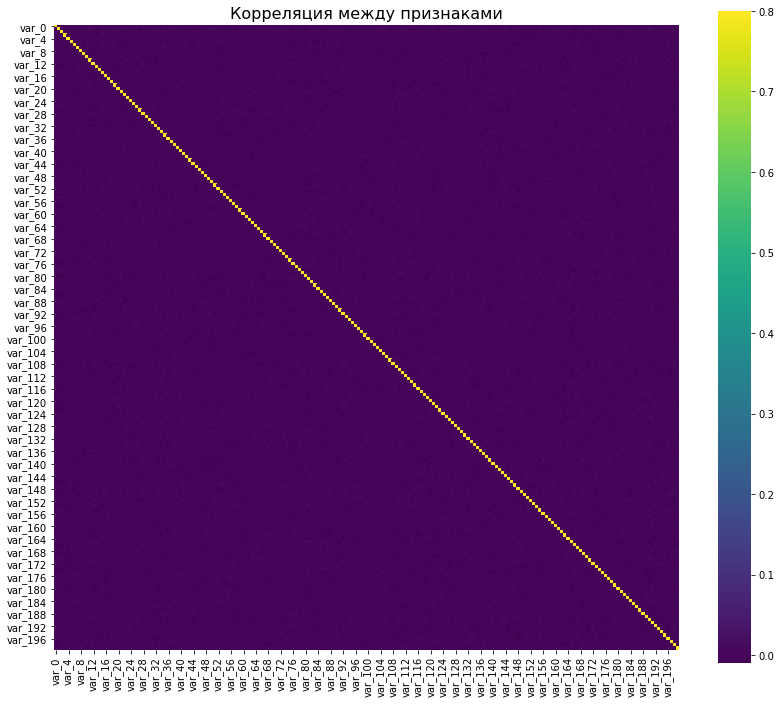

In [ ]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Корреляция между признаками", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")
plt.show()

In [ ]:
((correlation > 0.2).sum() > 1).sum()

0

Дополнительно посмотрим на линейную связь с целевой переменной

In [ ]:
target = train.target.copy()
corr_target_df = pd.DataFrame(columns= ['feature', 'corr with target'])
for f in features:
    corr_target_df.loc[corr_target_df.shape[0] + 1, 'feature'] = f
    corr_target_df.loc[corr_target_df.shape[0], 'corr with target'] = np.corrcoef(train[f], target)[0, 1]
corr_target_df.sort_values(by='corr with target', ascending = False).reset_index().head(10)

,index,feature,corr with target
0,7,var_6,0.0667308
1,111,var_110,0.0642753
2,54,var_53,0.0633986
3,27,var_26,0.0624222
4,23,var_22,0.0605584
5,100,var_99,0.058367
6,191,var_190,0.0559734
7,3,var_2,0.0558703
8,134,var_133,0.0545476
9,1,var_0,0.0523896


In [ ]:
(corr_target_df['corr with target'] > 0.2).sum()

0

#### Выводы:
1) Существенная корреляция признаков друг с другом отсутствует      
2) Ни один из признаков не имеет существенной линейной зависимости с целевой переменной 

####  Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [ ]:
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}
forest = RandomForestRegressor(**parameters)
forest.fit(train[features], target)

RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

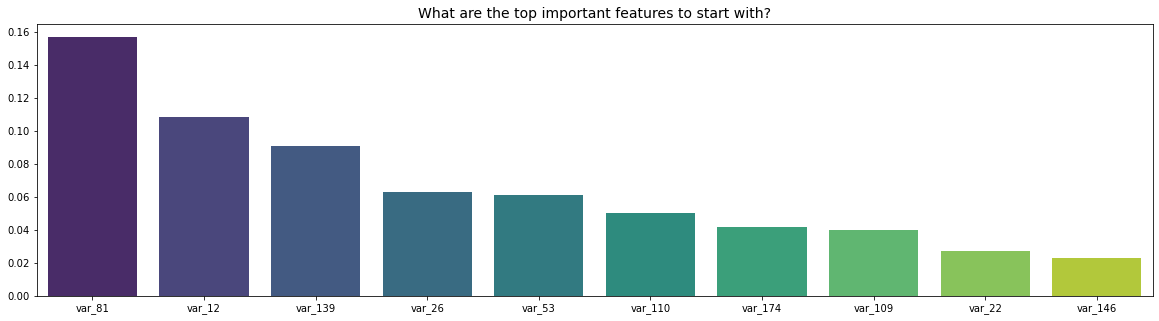

In [ ]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]

feature_names = np.array(features)

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

####  Задание 7: Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

Видимо сделано в задании 3